In [92]:
import spacy
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import ffmpeg
from pathlib import Path
import json
from tqdm import tqdm
import seaborn as sns

In [47]:
nlp = spacy.load("ru_core_news_sm")
id2name = json.load(Path('id2name.json').open('r', encoding='utf-8'))

# 0. Обработка данных

In [62]:
not_allowed = ['<', '>', ':', '"', '/', '\\', '|', '?', '*']

def caption2vidfile(caption):
    name = id2name.get(caption.stem)
    for symbol in not_allowed:
        name = name.replace(symbol, '')
    return Path('D:/YandexDisk/SLR Project') / (name + '.mp4')

In [38]:
def get_ministats(sentence):
    doc = nlp(sentence)
    lemmas = []
    bigrams = []
    trigrams = []
    word_count = 0
    for i in range(len(doc)):
        if not(doc[i].is_punct or doc[i].is_space):
            word_count += 1

            if not doc[i].is_stop:
                lemmas.append(doc[i].lemma_)

            if i > 0 and not(doc[i-1].is_punct or doc[i-1].is_space):
                bigrams.append((doc[i-1].lemma_, doc[i].lemma_))

                if i > 1 and not(doc[i-2].is_punct or doc[i-2].is_space):
                    trigrams.append((doc[i-2].lemma_, doc[i-1].lemma_, doc[i].lemma_))
    
    return {
        'word_count': word_count,
        'lemmas': lemmas,
        'bigrams': bigrams,
        'trigrams': trigrams
    }

In [71]:
captions = []
path_files = [fpath for fpath in Path('D:/YandexDisk/SLR Project_subs').iterdir()]


for caption_file in tqdm(path_files):
    vidfile = caption2vidfile(caption_file)
    
    vid_id = caption_file.stem
    vid_name = vidfile.stem
    vid_dur = float(ffmpeg.probe(vidfile)['format']['duration']) if vidfile.exists() else None
    
    for caption in json.load(caption_file.open('r', encoding='utf-8')):
        info_dct = caption.copy()
        info_dct.update({
            'vid_id': vid_id,
            'vid_name': vid_name,
            'vid_dur': vid_dur
        })
        info_dct.update(get_ministats(caption['text']))
        captions.append(info_dct)

100%|██████████| 321/321 [08:16<00:00,  1.55s/it]


In [75]:
df = pd.DataFrame(captions)

In [76]:
df.head()

,text,start,duration,vid_id,vid_name,vid_dur,word_count,lemmas,bigrams,trigrams
0,- Здравствуйте!,6.26,1.46,-fAgydbc3EI,Цель Сахалин. По следам Антона Павловича Чехов...,597.76,1,[здравствовать],[],[]
1,Сейчас мы представим наших двух героев.,7.88,2.88,-fAgydbc3EI,Цель Сахалин. По следам Антона Павловича Чехов...,597.76,6,"[представить, два, герой]","[(сейчас, мы), (мы, представить), (представить...","[(сейчас, мы, представить), (мы, представить, ..."
2,Василий Иванов. Он педагог школы №10 (по старо...,12.08,9.42,-fAgydbc3EI,Цель Сахалин. По следам Антона Павловича Чехов...,597.76,15,"[василий, иванов, педагог, школа, №, 10, стары...","[(василий, иванов), (он, педагог), (педагог, ш...","[(он, педагог, школа), (педагог, школа, №), (ш..."
3,"Второй – Алексей Знаменский. Он актёр, режиссё...",22.26,8.92,-fAgydbc3EI,Цель Сахалин. По следам Антона Павловича Чехов...,597.76,8,"[второй, алексей, знаменский, актёр, режиссёр,...","[(алексей, знаменский), (он, актёр), (режиссёр...",[]
4,"Мы пригласили их, хотим задать вопросы. В связ...",32.92,1.88,-fAgydbc3EI,Цель Сахалин. По следам Антона Павловича Чехов...,597.76,10,"[пригласить, хотеть, задать, вопрос, связь]","[(мы, пригласить), (пригласить, их), (хотеть, ...","[(мы, пригласить, их), (хотеть, задать, вопрос..."


# 1. Общие показатели

In [116]:
groupby_vid = df.groupby('vid_id').agg({'vid_dur': 'mean'})

total_vids = len(groupby_vid)
total_vid_dur = groupby_vid.vid_dur.sum() / 3600
total_words = df.word_count.sum()
total_replics_num = len(df)
total_replics_dur = df.duration.sum() / 3600
replics_vid_ratio_pc = (total_replics_dur / total_vid_dur) * 100

In [117]:
print(f'''
Всего {total_vids} видео общей длительностью {round(total_vid_dur, 2)} часов.
Всего {total_replics_num} реплик общей длительностью {round(total_replics_dur, 2)} часов, содержащих {total_words} слов.
В среднем реплики занимают {round(replics_vid_ratio_pc, 2)}% от общей продолжительности видео
''')


Всего 321 видео общей длительностью 54.98 часов.
Всего 30387 реплик общей длительностью 41.33 часов, содержащих 268313 слов.
В среднем реплики занимают 75.18% от общей продолжительности видео



# 2. Статистики по репликам

Text(0.5, 1.0, 'Распределение реплик по длительности')

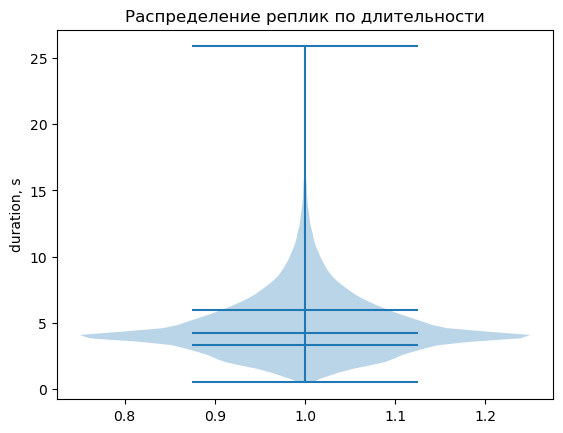

In [95]:
plt.figure()
plt.violinplot(df.duration, showmedians=True, quantiles=[0.25, 0.75])
plt.ylabel('duration, s')
plt.title('Распределение реплик по длительности')

Text(0.5, 1.0, 'Распределение реплик по количеству слов')

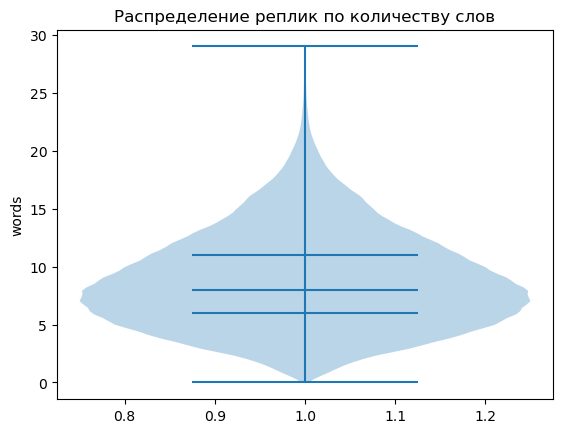

In [97]:
plt.figure()
plt.violinplot(df.word_count, showmedians=True, quantiles=[0.25, 0.75])
plt.ylabel('words')
plt.title('Распределение реплик по количеству слов')

# 3. Статистика по видео

In [126]:
groupby_vid = df.groupby('vid_id').agg({'vid_dur': 'mean', 'duration': 'sum', 'word_count': 'sum', 'text': 'count'}).dropna()

Text(0.5, 1.0, 'Распределение количества реплик на минуту видео')

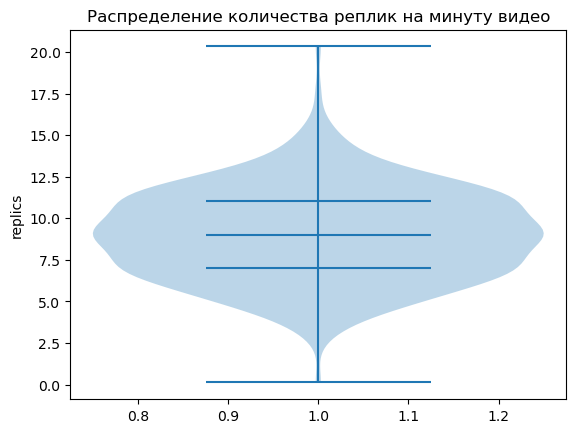

In [129]:
plt.figure()
plt.violinplot(groupby_vid.text / groupby_vid.vid_dur * 60, showmedians=True, quantiles=[0.25, 0.75])
plt.ylabel('replics')
plt.title('Распределение количества реплик на минуту видео')

Text(0.5, 1.0, 'Распределение отношения общей продолжительности реплик\nк продолжительности видео')

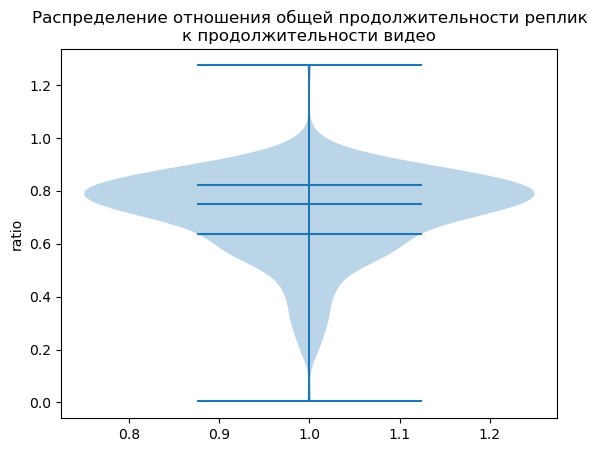

In [135]:
plt.figure()
plt.violinplot(groupby_vid.duration / groupby_vid.vid_dur, showmedians=True, quantiles=[0.25, 0.75], )
plt.ylabel('ratio')
plt.title('Распределение отношения общей продолжительности реплик\nк продолжительности видео')

(Значения больше 1 означают, что бывает наложение реплик друг на друга)

Text(0.5, 1.0, 'Распределение среднего количества слов на минуту видео')

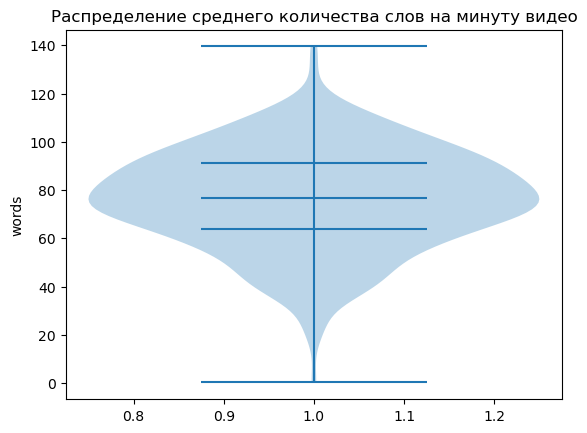

In [136]:
plt.figure()
plt.violinplot(groupby_vid.word_count / groupby_vid.vid_dur * 60, showmedians=True, quantiles=[0.25, 0.75])
plt.ylabel('words')
plt.title('Распределение среднего количества слов на минуту видео')

# 4. Текстовые метрики

## 4.1. Частотность слов

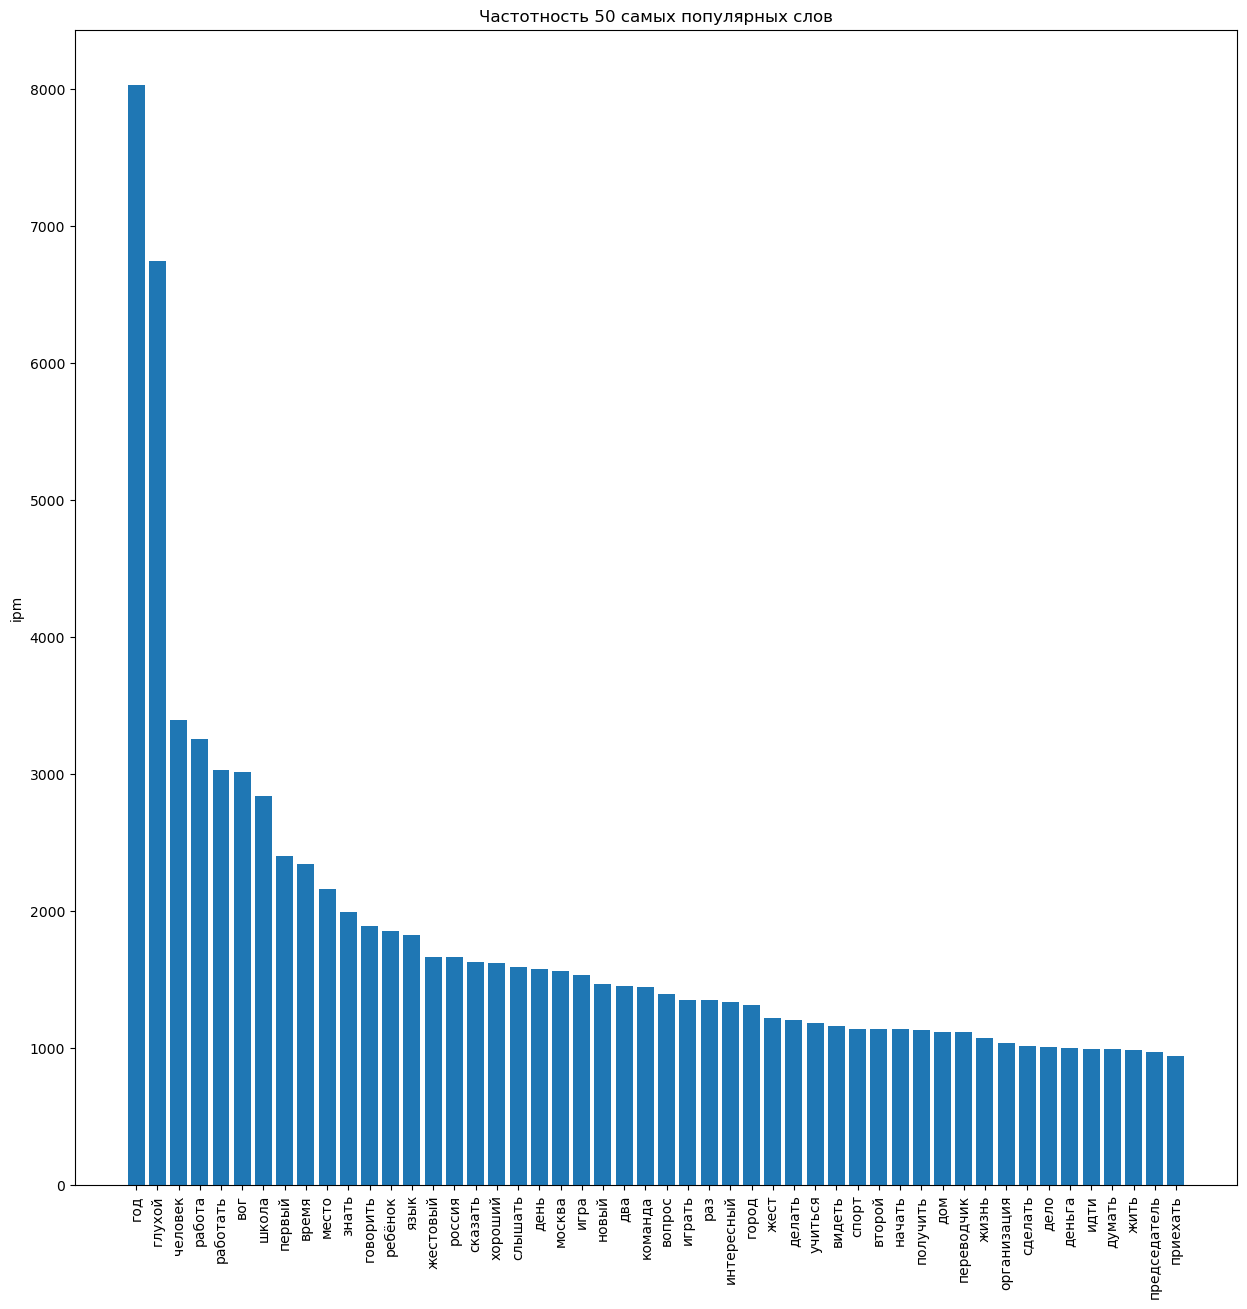

In [153]:
word_cnt = Counter()
df.lemmas.apply(word_cnt.update)
top_50 = word_cnt.most_common(50)


plt.figure(figsize=(15,15))
plt.bar(
    [pair[0] for pair in top_50],
    [pair[1] / total_words * 1e6 for pair in top_50]
)
plt.xticks(rotation=90)
plt.ylabel('ipm')
plt.title('Частотность 50 самых популярных слов')
plt.show()

## 4.2. Частотность биграм

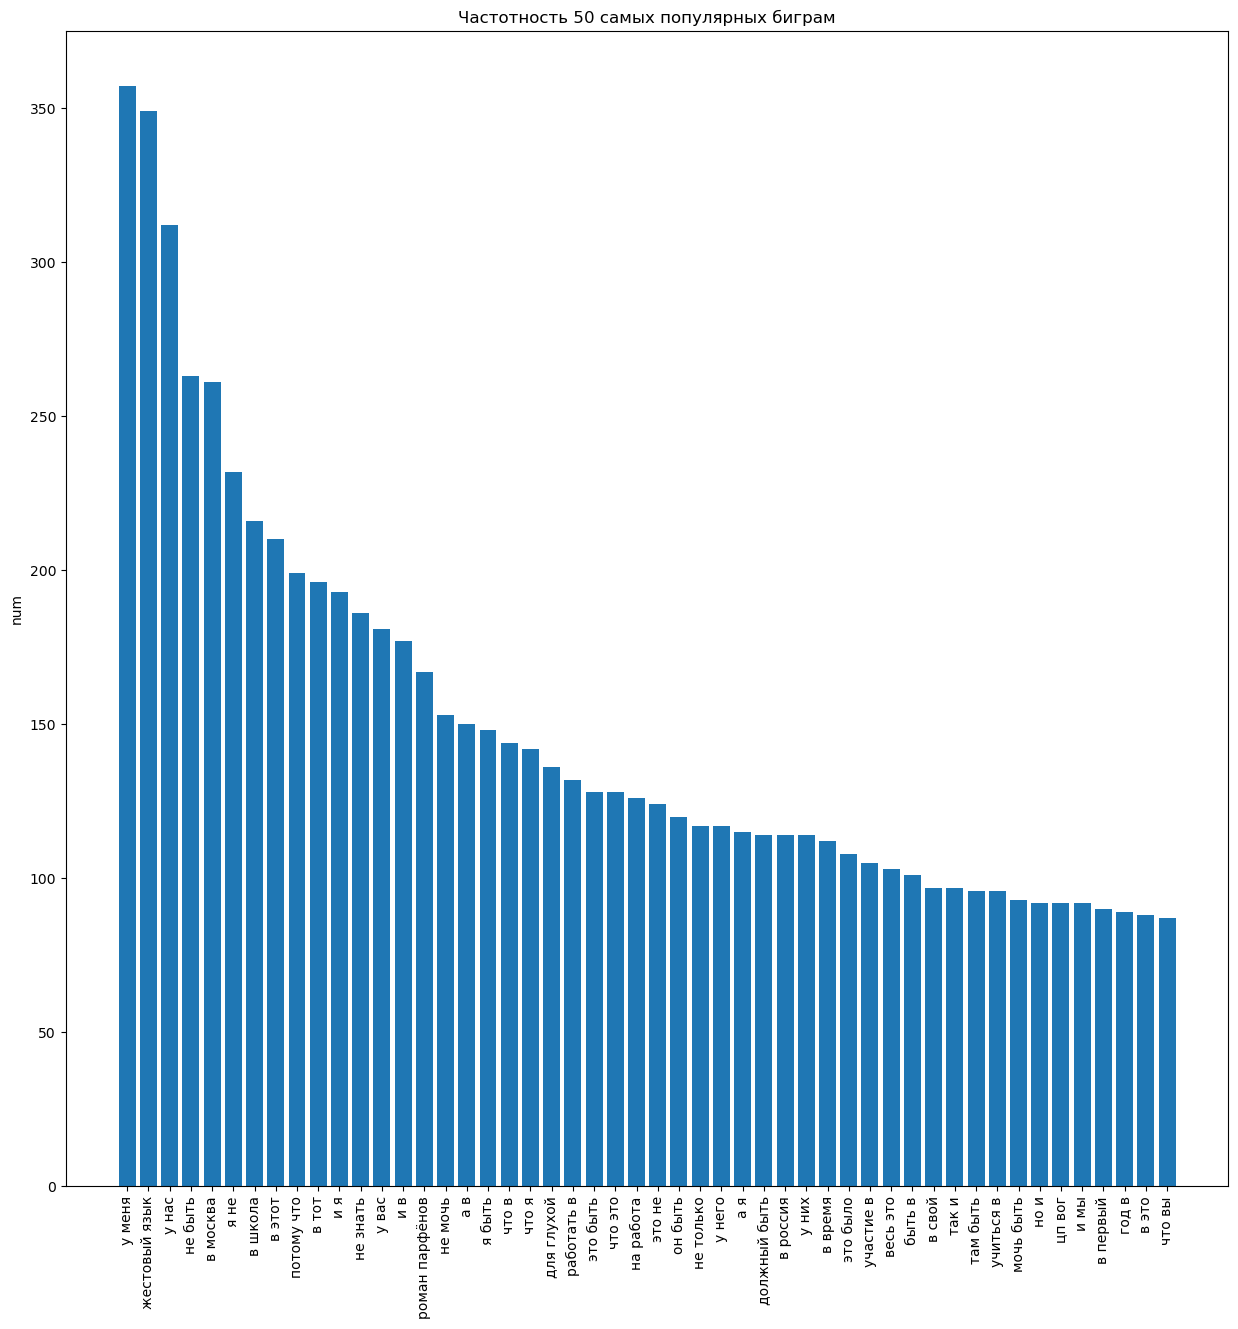

In [156]:
bigram_cnt = Counter()
df.bigrams.apply(bigram_cnt.update)
top_50 = bigram_cnt.most_common(50)


plt.figure(figsize=(15,15))
plt.bar(
    [' '.join(pair[0]) for pair in top_50],
    [pair[1] for pair in top_50]
)
plt.xticks(rotation=90)
plt.ylabel('num')
plt.title('Частотность 50 самых популярных биграм')
plt.show()

## 4.3. Частотность триграм

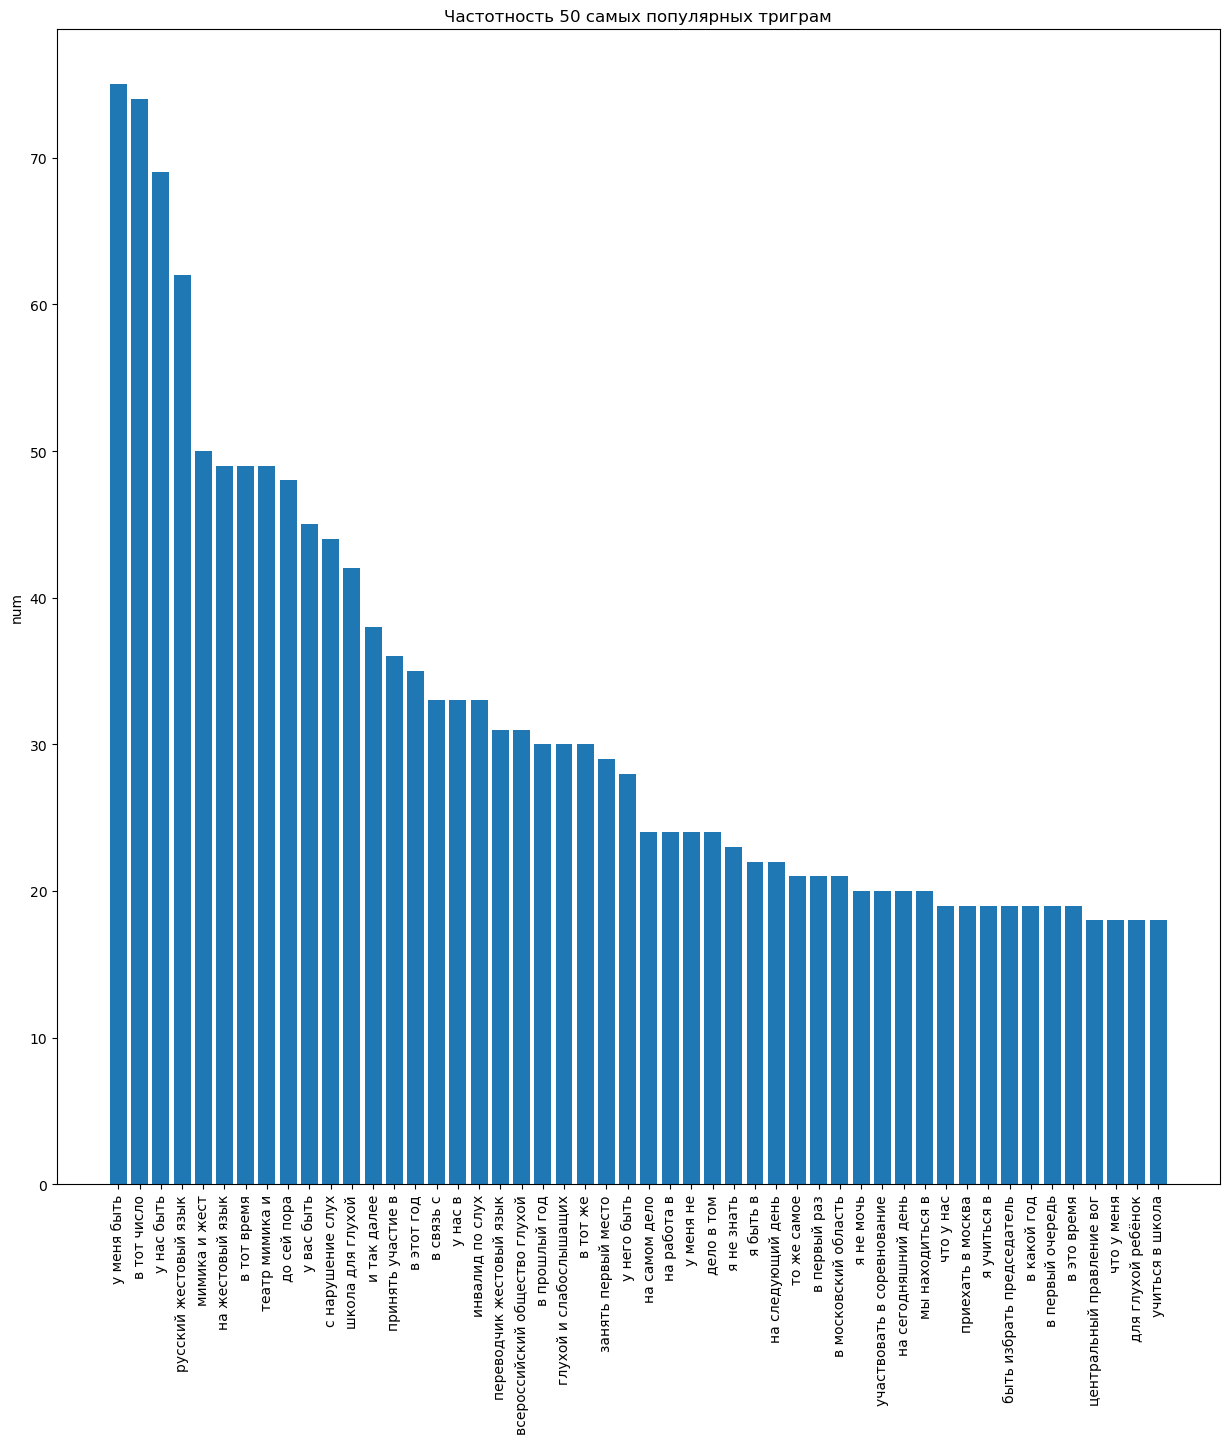

In [157]:
trigram_cnt = Counter()
df.trigrams.apply(trigram_cnt.update)
top_50 = trigram_cnt.most_common(50)


plt.figure(figsize=(15,15))
plt.bar(
    [' '.join(pair[0]) for pair in top_50],
    [pair[1] for pair in top_50]
)
plt.xticks(rotation=90)
plt.ylabel('num')
plt.title('Частотность 50 самых популярных триграм')
plt.show()

## 4.4. Облако слов😍

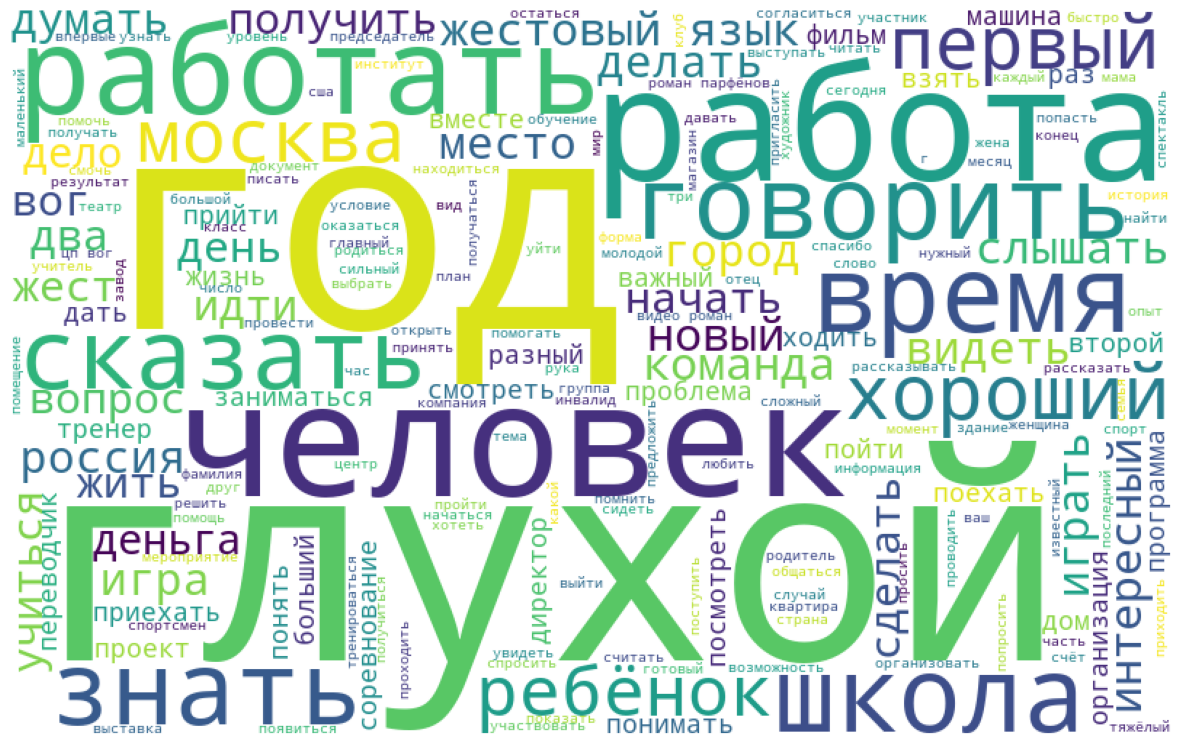

In [165]:
words_list = []
df.lemmas.apply(words_list.extend)

plt.figure(figsize=(15,15))
wc = WordCloud(background_color='white', width = 800, height = 500).generate(' '.join(words_list))
plt.axis('off')
plt.imshow(wc)